Dependencies:
* torch
* numpy
* natsort
* os
* tqdm
* matplotlib
* scipy

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set manual seed for reproducability
torch.manual_seed(9)

## Data preparation
Get train and test set

In [3]:
import os
import natsort
import numpy as np
from torch.utils import data

class GasDataSet(data.Dataset):
    """Create a custom PyTorch Dataset that can be used by PyTorch DataLoaders."""
    def __init__(self, root, max_val=1):
        self.root = root
        self.max_val = max_val
        
        files = []
        # Grab all files into the files array
        for season in natsort.natsorted(os.listdir(root)):
            for location in natsort.natsorted(os.listdir(os.path.join(root, season))):
                for file in natsort.natsorted(os.listdir(os.path.join(root, season, location))):
                    file_path = os.path.join(root, season, location, file)
                    files.append(file_path)
        self.files = files
        
    def __len__(self):
        return (len(self.files))
    
    def __getitem__(self, idx):
        """Return the next batch of data, when the DataLoader is quering the dataset."""
        path = self.files[idx]
        X = torch.Tensor(np.loadtxt(path, delimiter=','))
        
        # Add dimension to represent the channel (here: grayscale -> only 1 channel) 
        X = X.unsqueeze(0)
        
        X = X.log()
        X = torch.clamp(X, min=0)
        
        # Normalize the data by maximum value (default: 1)
        X = X/self.max_val
        
        return X 
    
    
def get_total_max(train_loader):
    """Find the maximum value of the training dataset."""
    total_max = 0
    for data in train_loader:
        this_max = data.max()

        if this_max > total_max: 
            total_max = this_max
            
    return total_max

# max_val = get_total_max(train_loader)
max_val = 15.4337
    
# Train data
train_dataset = GasDataSet('data/30x25/train', max_val=max_val)
train_loader = data.DataLoader(train_dataset, batch_size=30, shuffle=True, drop_last=True)

# Test data
test_dataset = GasDataSet('data/30x25/test', max_val=max_val)
test_loader = data.DataLoader(test_dataset, batch_size=30, shuffle=True, drop_last=True)

## Definition of Model & Training Loop

In [4]:
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


def create_mask(n):
    """Create a mask that simulates a sensor position at every n-th grid cell."""
    mask = torch.zeros([30, 25])

    for row in range(int(n/2), mask.shape[0], n):
        for col in range(int(n/2), mask.shape[1], n):
            mask[row, col] = 1

    return mask


def train(model, train_loader, num_epochs, criterion, optimizer):
    """Train the model with training data."""
    # Set model in training mode
    model.train()

    train_loss = []

    num_batches = len(train_loader)

    # Create a mask to generate sparse data
    mask = create_mask(n=5).to(device)

    # Initialize progress bars
    pbar_epoch = tqdm(total=num_epochs)
    pbar_epoch.set_description("Epochs")

    pbar_batch = tqdm(total=num_batches)
    pbar_batch.set_description("Batches")

    # Iterate over the epochs
    for epoch in range(num_epochs):
        running_loss = 0
        # Iterate over the batches
        for X in train_loader:
            X = X.to(device)
            # Create sparse input data
            X_masked = mask*X
            # Generate output
            y_hat = model(X_masked)

            # Calculate loss
            loss = criterion(y_hat, X)

            # Update weights according to the calculated loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Increment the loss
            running_loss += loss.item()

            pbar_batch.update(1)

        pbar_batch.reset()
        pbar_epoch.update(1)

        # Average the loss over entire batch
        running_loss /= num_batches
        train_loss.append(running_loss)

    # Plot the training loss
    plt.plot(range(1, num_epochs+1), train_loss)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training Loss")
    plt.show()

    return model


class model(torch.nn.Module):
    """The actual PyTorch model of the neural network."""

    def __init__(self):
        """Definition of all layers."""
        super().__init__()

        self.encoder = torch.nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=2,
                      padding=1),   # N, 16, 15, 13
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3, 3),
                      stride=2, padding=1),  # N, 32, 8, 7
            nn.ReLU(),
            # N, 64, 6, 5
            nn.Conv2d(32, 64, kernel_size=(3, 3)),
        )

        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(
                3, 3)),                      # N, 32, 8, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=(
                3, 3), stride=2, padding=1),  # N, 16, 15, 13
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1,  kernel_size=(3, 3),
                               stride=2, padding=1, output_padding=(1, 0)),      # N, 1, 30, 25
            # torch.nn.ReLU()
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        """Forward pass that will be performend, if the model is called."""
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Parameters & Training

In [5]:
# Instantiating the model and hyperparameters
model = model()
# Send model to device
model.to(device) 


# TRAINING PARAMETERS
criterion = nn.MSELoss()
num_epochs = 1          
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Train the model
#model = train(model, train_loader, num_epochs, criterion, optimizer)

Save & Load existing models

In [6]:
PATH = 'models/model_100epochs.pt'

# Save
# torch.save(model.state_dict(), PATH)

# Load
model.load_state_dict(torch.load(PATH, map_location=device))

# Set model to evaluation mode
model.eval()
model.to(device) 


model(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (5): Sigmoid()
  )
)

## Evaluation
Additional function for comparison of the autoencoder with interpolation.

In [7]:
import scipy.interpolate as interpolate

def interpolate_batch(X, function='gaussian'):
    """Interpolate a batch of size [batch, channel, width, height]"""
    all_interpolated = torch.empty([1,30,25])
    
    for sample in range(X.shape[0]):
        this_X = X[sample][0]
        
        r = np.linspace(0, 1, this_X.shape[0])
        c = np.linspace(0, 1, this_X.shape[1])

        rr, cc = np.meshgrid(c, r)
        vals = ~(this_X == 0)
        
        try:
            f = interpolate.Rbf(rr[vals], cc[vals], this_X[vals], function=function)
            interpolated = f(rr, cc)
        except:
            interpolated = this_X      

        interpolated = torch.tensor(interpolated)
        all_interpolated = torch.cat([all_interpolated, interpolated.unsqueeze(0)])
        
    all_interpolated = all_interpolated.unsqueeze(1)
    return all_interpolated[1:]



with torch.no_grad():
    mask = create_mask(n=5).to(device)
    mse_model = 0
    mse_inverse = 0
    mse_gaussian = 0
    
    # Calculate the average MSE for each batch
    for X in test_loader:
        X_masked = X.to(device) * mask.to(device)  
        
        pred = model(X_masked)
        mse_model += criterion(pred, X.to(device))
        
        inverse = interpolate_batch(X_masked.detach().cpu().numpy(), 'inverse')
        mse_inverse += criterion(inverse, X)
        
        gaussian = interpolate_batch(X_masked.detach().cpu().numpy(), 'gaussian')
        mse_gaussian += criterion(gaussian, X)
            
            
    num_test_batches = len(test_loader)
    
    # Calculate mean MSE by dividing summed MSE by number of batches
    mse_model = mse_model/num_test_batches
    mse_inverse = mse_inverse/num_test_batches
    mse_gaussian = mse_gaussian/num_test_batches
    
mse_model

tensor(0.0042)

# Visualizations

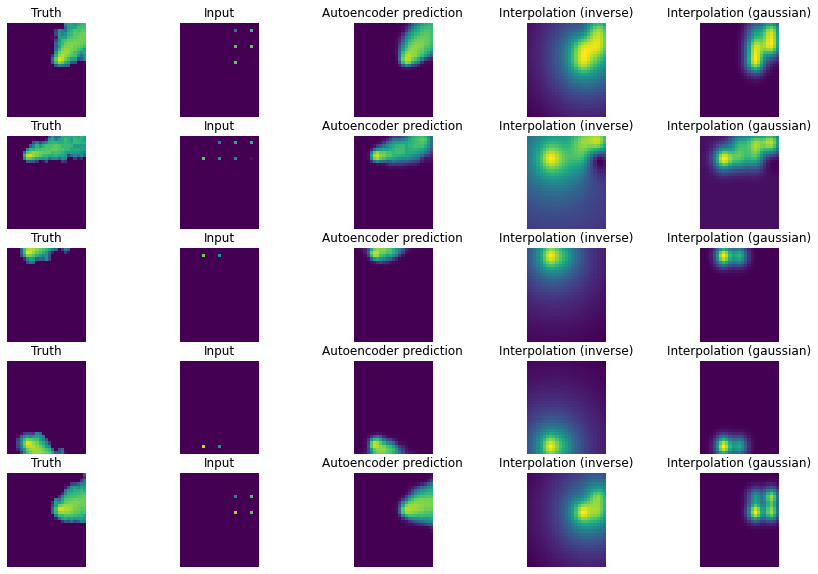

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = 15, 10

model.eval()


# INPUT
X = iter(test_loader).next()
mask = create_mask(5)
X_masked = X * mask

# PREDICTION
pred = model(X_masked.to(device))

# INTERPOLATION
inverse = interpolate_batch(X_masked.detach().cpu().numpy(), 'inverse')
gaussian = interpolate_batch(X_masked.detach().cpu().numpy(), 'gaussian')

for idx in range(1, 25, 5):
    # TRUTH
    plt.subplot(5, 5, idx)
    plt.title('Truth')
    plt.imshow(X[idx][0].detach().cpu().numpy(), cmap='viridis', vmin=0, vmax=1)
    plt.axis('off')   
    
    # INPUT
    plt.subplot(5, 5, idx+1)
    plt.title('Input')
    plt.imshow(X_masked[idx][0].detach().cpu().numpy(), cmap='viridis', vmin=0, vmax=1)
    plt.axis('off')   
    
    # PREDICTION
    plt.subplot(5, 5, (idx+2))
    plt.title('Autoencoder prediction')
    plt.imshow(pred[idx][0].detach().cpu().numpy(), cmap='viridis', vmin=0, vmax=1)
    plt.axis('off')

    # INTERPOLATION
    plt.subplot(5, 5, (idx+3))
    plt.title('Interpolation (inverse)')
    plt.imshow(inverse[idx][0])
    plt.axis('off')
    
    plt.subplot(5, 5, (idx+4))
    plt.title('Interpolation (gaussian)')
    plt.imshow(gaussian[idx][0])
    plt.axis('off')


plt.show()

Find best samples

In [ ]:


with torch.no_grad():
    mask = create_mask(n=5).to(device)
    mse_model = 0
    mse_inverse = 0
    mse_gaussian = 0
    
    # Calculate the average MSE for each batch
    for X in test_loader:
        X_masked = X.to(device) * mask.to(device)  
        
        pred = model(X_masked)
        mse_model += criterion(pred, X.to(device))
        
        inverse = interpolate_batch(X_masked.detach().cpu().numpy(), 'inverse')
        mse_inverse += criterion(inverse, X)
        
        gaussian = interpolate_batch(X_masked.detach().cpu().numpy(), 'gaussian')
        mse_gaussian += criterion(gaussian, X)